### **The GitHub Branching process**

**Open your terminal**
- file -> new terminal 

**Ensure you are on main and up to date**
- git checkout main
- git pull origin main

**Create and switch to new branch**
- git checkout -b your-name/feature-description

**Add your changes (specific)**
- git add notebooks/task_1.ipynb

**Or add all changes**
- git add .

**Commit with clear message**
- git commit -m "Complete data cleaning for task 1"
- git push origin dhruv/task1-analysis

**Go to GitHub and open a Pull Request**



**1.1. Roadmap** 
1. getting our data
2. look at basic info - shape, info, missingness
3. Figure out target variable categories 
4. sample - stratify to mainatain balance between classes
5. save sampled data to new csv 
6. EDA and visualisations 
7. encode the target variable (there are 8 variable types, maybe label encode)



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px 
import plotly.graph_objects as go

import missingno as msno 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("../data/raw/data-1.csv")
df.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
0,valley floor / meadow,0,0,0.0174,0.0131,0.0108,0.0133,0.0158,0.0144,0.0151,...,0.0237,0.0231,0.0224,0.0246,0.0255,0.0174,0.0234,0.0147,#030B05,#25C77140
1,valley floor / meadow,1,0,0.0180,0.0124,0.0116,0.0143,0.0154,0.0136,0.0151,...,0.0289,0.0275,0.0288,0.0293,0.0286,0.0211,0.0229,0.0176,#040A09,#25C77140
2,valley floor / meadow,2,0,0.0151,0.0150,0.0113,0.0158,0.0167,0.0158,0.0163,...,0.0358,0.0319,0.0355,0.0274,0.0303,0.0232,0.0282,0.0181,#08110B,#25C77140
3,valley floor / meadow,3,0,0.0172,0.0149,0.0095,0.0156,0.0154,0.0169,0.0176,...,0.0310,0.0294,0.0307,0.0238,0.0304,0.0232,0.0247,0.0087,#0C160C,#25C77140
4,valley floor / meadow,4,0,0.0184,0.0149,0.0143,0.0189,0.0174,0.0174,0.0182,...,0.0428,0.0372,0.0407,0.0344,0.0415,0.0287,0.0317,0.0176,#0E180C,#25C77140


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215604 entries, 0 to 215603
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 366.8+ MB


In [4]:
df.describe()

,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
count,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,...,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000
mean,176.934871,303.167789,0.095601,0.094335,0.095621,0.099081,0.100492,0.101252,0.102764,0.104476,...,0.110929,0.108438,0.108563,0.105381,0.105773,0.100424,0.099806,0.095834,0.092850,0.086839
std,102.491875,175.323061,0.164291,0.163833,0.165067,0.166807,0.167414,0.167216,0.167939,0.168141,...,0.059208,0.059431,0.059182,0.059277,0.058764,0.057765,0.056946,0.057251,0.054999,0.056024
min,0.000000,0.000000,-0.012000,-0.012600,-0.011900,-0.008800,-0.009300,-0.009000,-0.007700,-0.007500,...,0.007400,0.005700,0.006900,0.003600,0.006800,0.002400,0.004100,0.001100,0.000100,-0.010000
25%,88.000000,151.000000,0.022600,0.020600,0.020000,0.022900,0.023400,0.023800,0.024500,0.025500,...,0.058600,0.055700,0.056000,0.052500,0.053500,0.048900,0.048900,0.044400,0.043600,0.036300
50%,177.000000,303.000000,0.037800,0.036800,0.037700,0.040600,0.041600,0.042200,0.043400,0.045300,...,0.101100,0.098200,0.098200,0.094900,0.095000,0.089600,0.089000,0.085100,0.082300,0.076000
75%,266.000000,455.000000,0.078000,0.078000,0.081100,0.083800,0.086100,0.087700,0.090000,0.092700,...,0.157700,0.155500,0.155300,0.152500,0.152300,0.146400,0.145100,0.141500,0.136700,0.132000
max,354.000000,607.000000,1.581000,1.574100,1.587100,1.595900,1.603600,1.605300,1.609500,1.613800,...,0.453700,0.446600,0.453600,0.449000,0.446700,0.429900,0.435100,0.433000,0.429100,0.411200


In [29]:
# lets take a look at unique values for land_type
df["land_type"].unique()
df["land_type"].value_counts()

land_type
alpine meadow            50657
alpine tundra            38900
valley floor / meadow    38424
bare rock                26314
veg-scree mix            24495
scree / sunlit rock      15153
snow / ice               11533
dark rock                10128
Name: count, dtype: int64

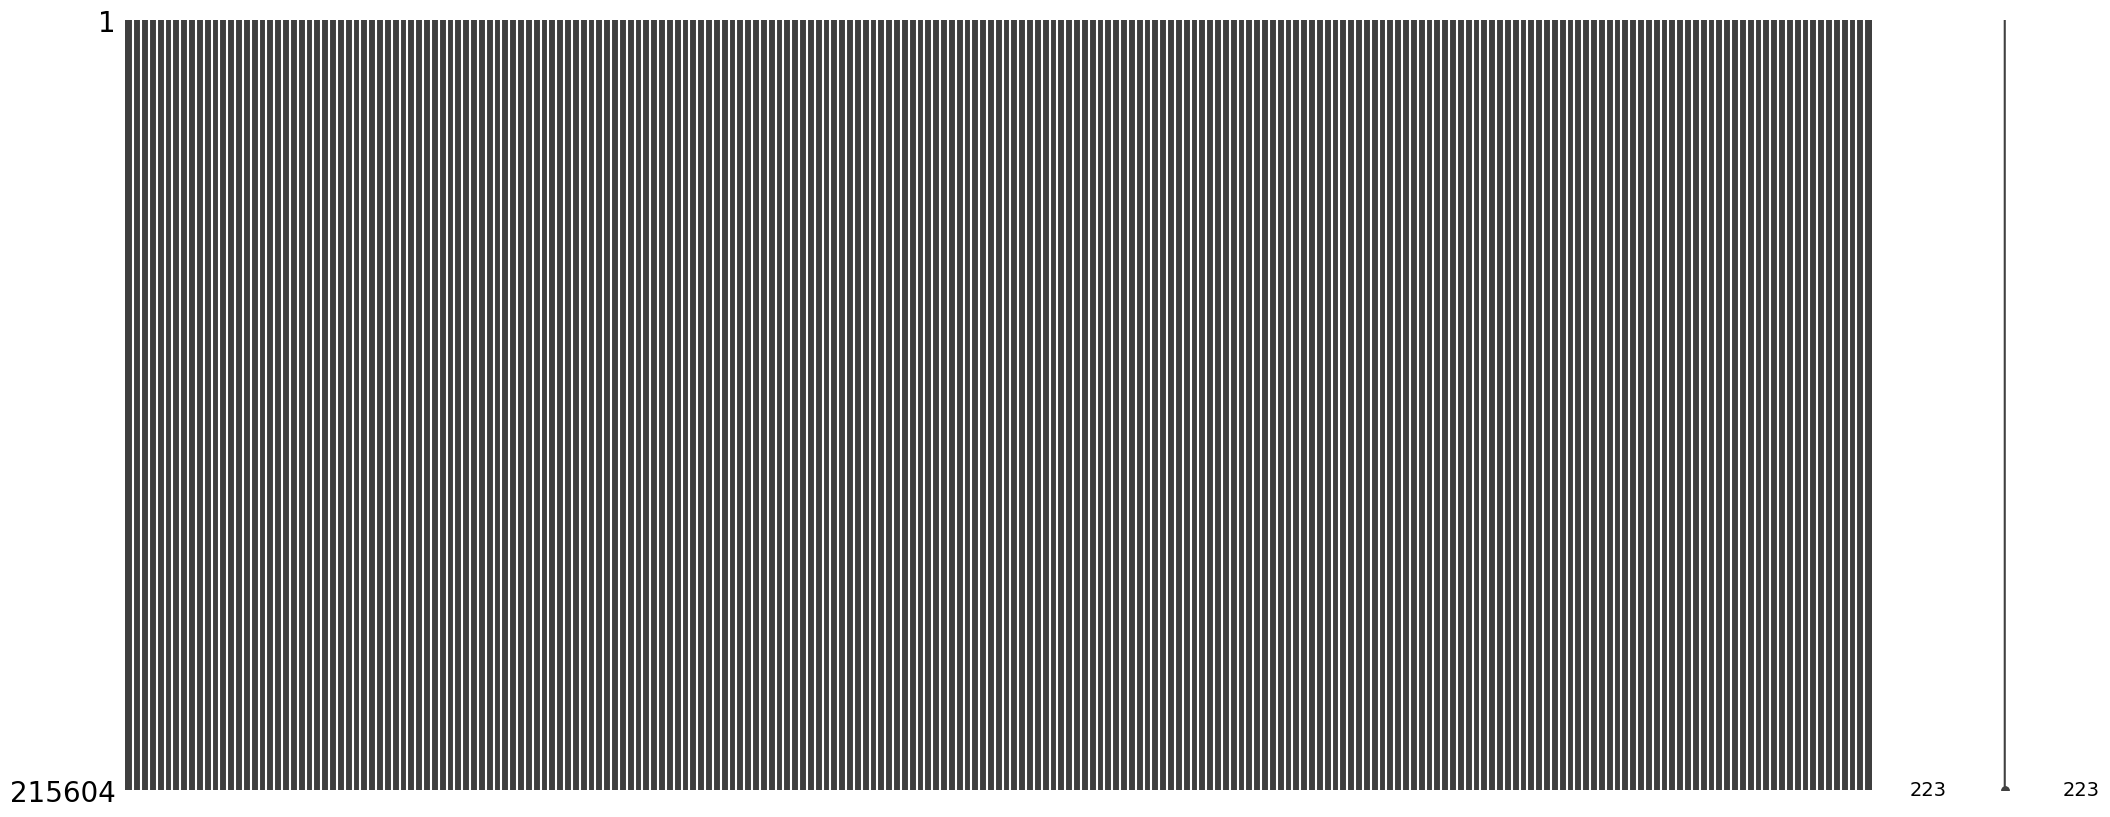

In [30]:
# lets visualise missing data 
msno.matrix(df)
plt.show()

In [3]:
# Stratified sampling the RIGHT way:
sample_size = 50000
sample_fraction = sample_size / len(df)

df_sample = df.groupby('land_type', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42)
)

C:\Users\reshm\AppData\Local\Temp\ipykernel_13760\491869911.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('land_type', group_keys=False).apply(


In [32]:
df_sample.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
15920,alpine meadow,300,44,0.0238,0.0214,0.0202,0.0223,0.0228,0.0231,0.0257,...,0.0616,0.0567,0.0573,0.0523,0.0508,0.0488,0.0473,0.0428,#1B1A13,#4B005540
91192,alpine meadow,312,256,0.0359,0.0361,0.0365,0.0399,0.0384,0.0388,0.0399,...,0.0930,0.0889,0.0897,0.0812,0.0814,0.0801,0.0748,0.0659,#2B2F21,#4B005540
108272,alpine meadow,352,304,0.0266,0.0248,0.0241,0.0257,0.0286,0.0278,0.0270,...,0.0709,0.0648,0.0663,0.0619,0.0586,0.0544,0.0528,0.0522,#1C1F15,#4B005540
189652,alpine meadow,82,534,0.0200,0.0181,0.0171,0.0198,0.0196,0.0202,0.0204,...,0.0465,0.0439,0.0427,0.0418,0.0400,0.0344,0.0368,0.0324,#0F0E0E,#4B005540
202127,alpine meadow,132,569,0.0410,0.0375,0.0364,0.0406,0.0419,0.0405,0.0427,...,0.0982,0.0917,0.0983,0.0924,0.0843,0.0749,0.0816,0.0724,#292E22,#4B005540


In [33]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50001 entries, 15920 to 197545
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 85.5+ MB


In [13]:
# Save sample to data/raw folder
df_sample.to_csv('../data/raw/data_sample.csv', index=False)

In [6]:
df_sample_land_type = df_sample['land_type'].value_counts()
df_sample_land_type

land_type
alpine meadow            11748
alpine tundra             9021
valley floor / meadow     8911
bare rock                 6102
veg-scree mix             5681
scree / sunlit rock       3514
snow / ice                2675
dark rock                 2349
Name: count, dtype: int64

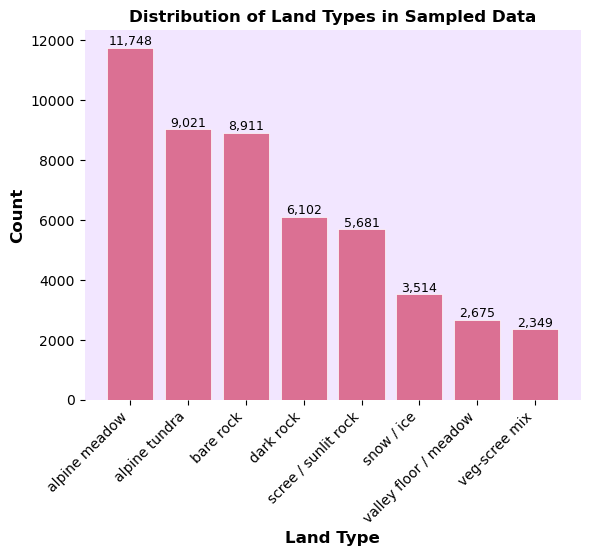

<Figure size 1000x800 with 0 Axes>

In [7]:
bars = plt.bar(df_sample['land_type'].unique(), df_sample_land_type, color='palevioletred', edgecolor='white', linewidth=0.5) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)
    
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(False)
plt.gca().spines['bottom'].set_linewidth(False)
plt.gca().set_facecolor('#f2e6ff')
plt.title('Distribution of Land Types in Sampled Data', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Land Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')


plt.figure(figsize=(10,8))
plt.show()

In [8]:
perc_real = (df['land_type'].value_counts() / len(df)) * 100
perc_sample = (df_sample['land_type'].value_counts() / len(df_sample)) * 100

pd.DataFrame({
    'Real Data Percentage': perc_real,
    'Sampled Data Percentage': perc_sample
})

,Real Data Percentage,Sampled Data Percentage
land_type,,
alpine meadow,23.495390,23.495530
alpine tundra,18.042337,18.041639
valley floor / meadow,17.821562,17.821644
bare rock,12.204783,12.203756
veg-scree mix,11.361106,11.361773
scree / sunlit rock,7.028163,7.027859
snow / ice,5.349159,5.349893
dark rock,4.697501,4.697906


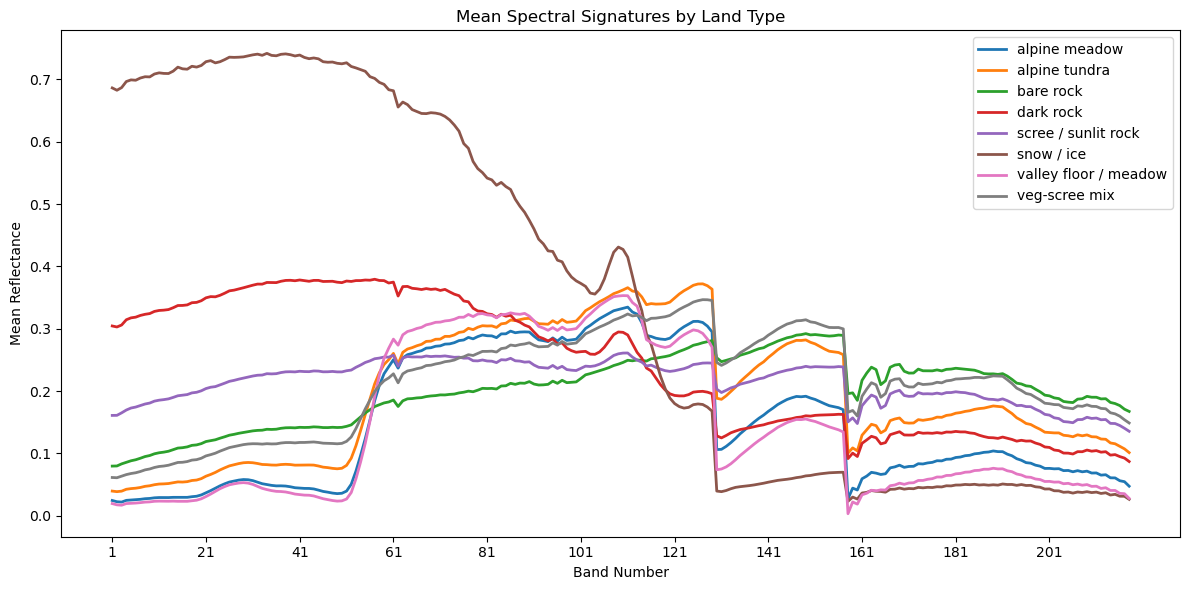

In [9]:
# Get the band columns
band_columns = [f'Band_{i}' for i in range(1, 219)]

# Create the plot
plt.figure(figsize=(12, 6))

# For each land type, calculate and plot the mean reflectance
for land_type in df_sample['land_type'].unique():
    # Get rows for this land type
    land_data = df_sample[df_sample['land_type'] == land_type]
    
    # Calculate mean reflectance for each band
    mean_reflectance = land_data[band_columns].mean()
    
    # Plot it
    plt.plot(mean_reflectance, label=land_type, linewidth=2)

# Add labels and legend
plt.xticks(ticks=np.arange(0, 219, 20), labels=np.arange(1, 218, 20))
plt.xlabel('Band Number')
plt.ylabel('Mean Reflectance')
plt.title('Mean Spectral Signatures by Land Type')
plt.legend()
plt.tight_layout()
plt.show()

This line plot shows us the mean reflectance of each land type. (eg. ice is way more reflective)

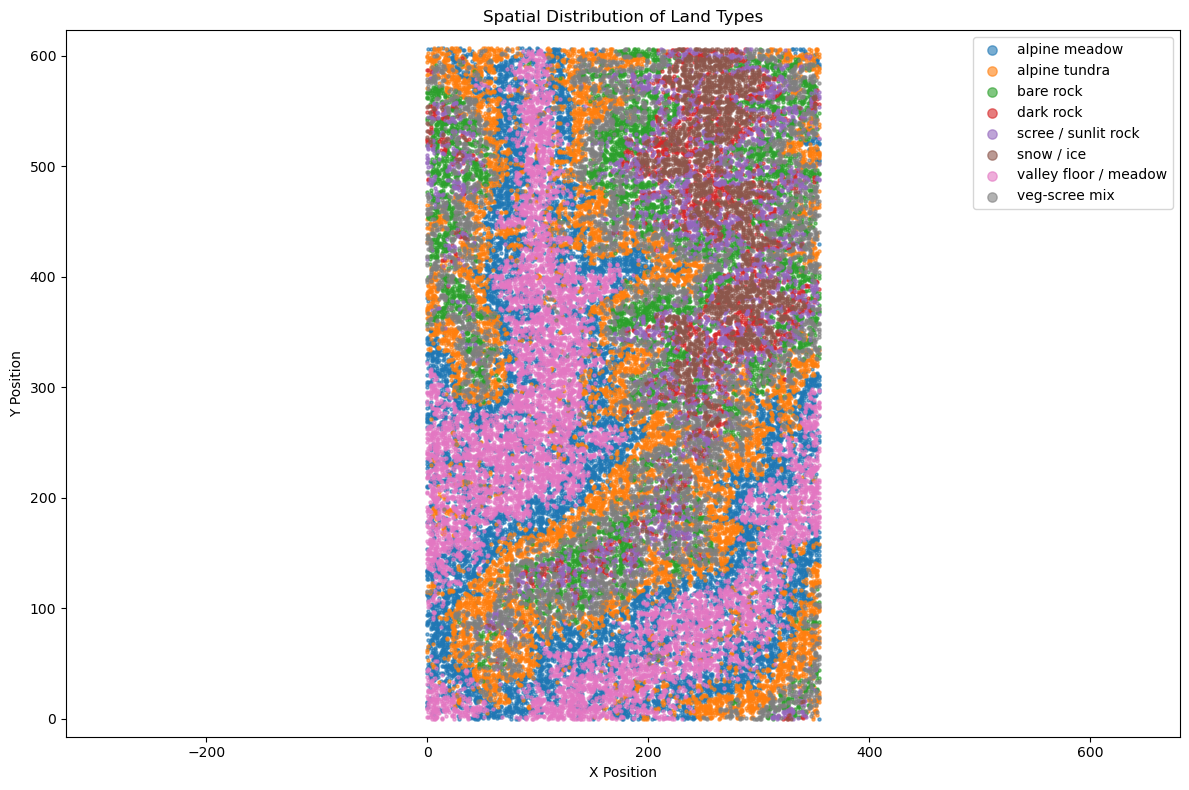

In [10]:
plt.figure(figsize=(12, 8))

# Plot each land type with different color
for land_type in df_sample['land_type'].unique():
    land_data = df_sample[df_sample['land_type'] == land_type]
    plt.scatter(land_data['p_x'], land_data['p_y'], 
                label=land_type, alpha=0.6, s=5)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Spatial Distribution of Land Types')
plt.legend(markerscale=3)
plt.axis('equal')  # Makes x and y scales the same
plt.tight_layout()
plt.show()

### **Encoding Target**

- Convert categorical land_type labels into numerical values (0-7)

- LabelEncoder assigns a unique integer to each vegetation class

- Save mapping so we can interpret results later
- Keep original 'land_type' column for reference during EDA

In [4]:
# Create label encoder
le = LabelEncoder()

# Encode land_type to numerical values
df_sample['land_type_encoded'] = le.fit_transform(df_sample['land_type'])

# Check mapping
print("Class mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")
    
print(f"\nOriginal: {df_sample['land_type'].head()}")
print(f"Encoded: {df_sample['land_type_encoded'].head()}")

Class mapping:
0: alpine meadow
1: alpine tundra
2: bare rock
3: dark rock
4: scree / sunlit rock
5: snow / ice
6: valley floor / meadow
7: veg-scree mix

Original: 15920     alpine meadow
91192     alpine meadow
108272    alpine meadow
189652    alpine meadow
202127    alpine meadow
Name: land_type, dtype: object
Encoded: 15920     0
91192     0
108272    0
189652    0
202127    0
Name: land_type_encoded, dtype: int32


In [5]:
# Select only the spectral bands as features
band_columns = [f'Band_{i}' for i in range(1, 219)]  # Band_1 to Band_218
X = df_sample[band_columns]

# Set target variable
y = df_sample['land_type_encoded']

# Check dimensions
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFirst few features:\n{X.head()}")

Feature matrix shape: (50001, 218)
Target vector shape: (50001,)

First few features:
        Band_1  Band_2  Band_3  Band_4  Band_5  Band_6  Band_7  Band_8  \
15920   0.0238  0.0214  0.0202  0.0223  0.0228  0.0231  0.0257  0.0248   
91192   0.0359  0.0361  0.0365  0.0399  0.0384  0.0388  0.0399  0.0421   
108272  0.0266  0.0248  0.0241  0.0257  0.0286  0.0278  0.0270  0.0285   
189652  0.0200  0.0181  0.0171  0.0198  0.0196  0.0202  0.0204  0.0215   
202127  0.0410  0.0375  0.0364  0.0406  0.0419  0.0405  0.0427  0.0435   

        Band_9  Band_10  ...  Band_209  Band_210  Band_211  Band_212  \
15920   0.0255   0.0261  ...    0.0610    0.0577    0.0616    0.0567   
91192   0.0419   0.0428  ...    0.0952    0.0957    0.0930    0.0889   
108272  0.0277   0.0294  ...    0.0728    0.0707    0.0709    0.0648   
189652  0.0207   0.0226  ...    0.0474    0.0439    0.0465    0.0439   
202127  0.0441   0.0465  ...    0.1103    0.0993    0.0982    0.0917   

        Band_213  Band_214  Band_215

### **Train-Test Split**

- We split our data into 80% training and 20% test sets to evaluate model performance

- We use stratified splitting to maintain the same class proportions in both train and test sets

- We set random_state=42 for reproducibility so our results are consistent

- We verify the split worked correctly and classes are balanced across both sets

In [6]:
from sklearn.model_selection import train_test_split

# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

# Check split sizes
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train set:")
print(y_train.value_counts().sort_index())

Training set: (40000, 218)
Test set: (10001, 218)

Class distribution in train set:
land_type_encoded
0    9398
1    7217
2    4881
3    1879
4    2811
5    2140
6    7129
7    4545
Name: count, dtype: int64


- We standardize all 218 spectral bands to have mean=0 and std=1

- We fit the scaler only on training data to prevent data leakage from test set

- We apply the same transformation to test data using the training set's parameters

- Scaling is crucial for PCA since it's sensitive to feature magnitudes

In [7]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling worked
print(f"Original training data - Mean: {X_train.mean().mean():.3f}, Std: {X_train.std().mean():.3f}")
print(f"Scaled training data - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

Original training data - Mean: 0.190, Std: 0.104
Scaled training data - Mean: 0.000, Std: 1.000


### **Linear Discriminant Analysis**

In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid (fixed - avoid invalid combinations)
param_grid_lda = [
    {'solver': ['svd']},  # SVD doesn't use shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.7]}
]

# GridSearchCV
lda_grid = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid_lda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting LDA hyperparameter tuning...")
lda_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {lda_grid.best_params_}")
print(f"Best CV accuracy: {lda_grid.best_score_:.4f}")

Starting LDA hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters: {'shrinkage': 0.7, 'solver': 'lsqr'}
Best CV accuracy: 0.8683


### **Quadratic Discriminant Analysis**

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Define hyperparameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
}

# GridSearchCV
qda_grid = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting QDA hyperparameter tuning...")
qda_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {qda_grid.best_params_}")
print(f"Best CV accuracy: {qda_grid.best_score_:.4f}")

Starting QDA hyperparameter tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'reg_param': 0.3}
Best CV accuracy: 0.9575


### **k-NN (Nearest Neighbours)**

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting k-NN hyperparameter tuning...")
knn_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV accuracy: {knn_grid.best_score_:.4f}")

Starting k-NN hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV accuracy: 0.9726


### **Logistic Classifier**

In [8]:
# Initialize baseline logistic regression
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Train on PCA training data
log_reg_baseline.fit(X_train_scaled, y_train)

# Quick baseline performance check
y_pred_baseline = log_reg_baseline.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.9897


In [9]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'saga'],  # Different solvers
    'max_iter': [2000]  # Increased to fix convergence
}

# Initialize GridSearchCV with 5-fold cross-validation
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Starting hyperparameter tuning...")
log_reg_grid.fit(X_train_scaled, y_train)

# Best parameters
print(f"\nBest parameters: {log_reg_grid.best_params_}")
print(f"Best CV accuracy: {log_reg_grid.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9900


### **Support Vector Machine**

In [10]:
from sklearn.svm import SVC


# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9932


In [11]:
# Retrain SVM with tuned hyperparameters + probability enabled
svm_with_proba = SVC(C=100, gamma='scale', kernel='rbf', 
                     probability=True, random_state=42)

print("Retraining SVM with probability=True...")
svm_with_proba.fit(X_train_scaled, y_train)

print("✓ SVM retrained with probability enabled for AUC calculation")

Retraining SVM with probability=True...
✓ SVM retrained with probability enabled for AUC calculation


### **Random Forest**

In [12]:
from sklearn.ensemble import RandomForestClassifier


# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV accuracy: 0.9747


### **Gradient Boosting Decision Trees**

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Just train GBDT
gbdt_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

print("Training GBDT...")
gbdt_model.fit(X_train_scaled, y_train)

# Quick check
y_pred_gbdt = gbdt_model.predict(X_test_scaled)
print(f"✓ GBDT accuracy: {accuracy_score(y_test, y_pred_gbdt):.4f}")

Training GBDT...
✓ GBDT accuracy: 0.9728


### **Evaluation**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import numpy as np

# Recreate models with best parameters from your tuning results
models = {
    'LDA': LinearDiscriminantAnalysis(
        shrinkage=0.7, 
        solver='lsqr'
    ),
    'Logistic Regression': LogisticRegression(
        C=10, 
        max_iter=2000, 
        penalty='l2', 
        solver='lbfgs',
        random_state=42
    ),
    'QDA': QuadraticDiscriminantAnalysis(
        reg_param=0.3
    ),
    'k-NN': KNeighborsClassifier(
        metric='manhattan', 
        n_neighbors=11, 
        weights='distance'
    ),
    'SVM': SVC(
        C=100, 
        gamma='scale', 
        kernel='rbf',
        probability=True,  # Needed for AUC calculation
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        max_depth=None, 
        min_samples_leaf=2, 
        min_samples_split=5, 
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    'GBDT': GradientBoostingClassifier(
        random_state=42,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
    )
}

# Train all models and store predictions
print("Training models...")
predictions = {}
probabilities = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    predictions[name] = model.predict(X_test_scaled)

    if hasattr(model, 'predict_proba'):
        probabilities[name] = model.predict_proba(X_test_scaled)
    
print("Done!")

Training models...
Training LDA...
Training Logistic Regression...
Training QDA...
Training k-NN...
Training SVM...
Training Random Forest...
Training GBDT...
Done!


In [9]:
# Initialize storage for results
results = {
    'Model': [],
    'Misclassification Error': [],
    'Accuracy': []
}

# Calculate basic metrics for each model
for name in models.keys():
    y_pred = predictions[name]
     
    # 1. Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # 2. Misclassification error rate
    misclass_error = 1 - accuracy
    
    # Store results
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Misclassification Error'].append(misclass_error)

# Quick preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy
0                  LDA                 0.127687  0.872313
1  Logistic Regression                 0.010099  0.989901
2                  QDA                 0.038296  0.961704
3                 k-NN                 0.025597  0.974403
4                  SVM                 0.005199  0.994801
5        Random Forest                 0.023498  0.976502
6                 GBDT                 0.027197  0.972803


##### **Balanced Accuracy**

In [10]:
# Add Balanced Accuracy to results
balanced_acc_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    balanced_acc_per_class = []
    
    # Calculate balanced accuracy for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Balanced accuracy = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_k = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_per_class.append(balanced_acc_k)
    
    # Average across all classes
    avg_balanced_acc = np.mean(balanced_acc_per_class)
    balanced_acc_list.append(avg_balanced_acc)

# Add to results
results['Balanced Accuracy'] = balanced_acc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy
0                  LDA                 0.127687  0.872313           0.923457
1  Logistic Regression                 0.010099  0.989901           0.992760
2                  QDA                 0.038296  0.961704           0.977392
3                 k-NN                 0.025597  0.974403           0.984456
4                  SVM                 0.005199  0.994801           0.996439
5        Random Forest                 0.023498  0.976502           0.985151
6                 GBDT                 0.027197  0.972803           0.983943


##### **F1-Score**

In [11]:
# Add Average F1 to results
f1_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    n_classes = len(np.unique(y_test))
    f1_per_class = []
    
    # Calculate F1 for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate Precision and Recall
        precision_k = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_k = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 = harmonic mean of precision and recall
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k) if (precision_k + recall_k) > 0 else 0
        f1_per_class.append(f1_k)
    
    # Average across all classes
    avg_f1 = np.mean(f1_per_class)
    f1_list.append(avg_f1)

# Add to results
results['Average F1'] = f1_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy  \
0                  LDA                 0.127687  0.872313           0.923457   
1  Logistic Regression                 0.010099  0.989901           0.992760   
2                  QDA                 0.038296  0.961704           0.977392   
3                 k-NN                 0.025597  0.974403           0.984456   
4                  SVM                 0.005199  0.994801           0.996439   
5        Random Forest                 0.023498  0.976502           0.985151   
6                 GBDT                 0.027197  0.972803           0.983943   

   Average F1  
0    0.869647  
1    0.987324  
2    0.960744  
3    0.973656  
4    0.993723  
5    0.974358  
6    0.972541  


##### **Area Under Curve (AUC)**

In [12]:
# Add Average AUC to results
auc_list = []

# Calculate for each model
for name, model in models.items():
    y_pred = predictions[name]
    
    # Get prediction probabilities (needed for AUC)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_scaled)
        
        n_classes = len(np.unique(y_test))
        auc_per_class = []
        
        # Calculate AUC for each class k (one-vs-rest)
        for k in range(n_classes):
            # Convert to binary: class k vs rest
            y_test_binary = (y_test == k).astype(int)
            
            # AUC using probability of class k
            auc_k = roc_auc_score(y_test_binary, y_pred_proba[:, k])
            auc_per_class.append(auc_k)
        
        # Average across all classes
        avg_auc = np.mean(auc_per_class)
        auc_list.append(avg_auc)
    else:
        # Model doesn't support predict_proba
        auc_list.append(np.nan)

# Add to results
results['Average AUC'] = auc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy  \
0                  LDA                 0.127687  0.872313           0.923457   
1  Logistic Regression                 0.010099  0.989901           0.992760   
2                  QDA                 0.038296  0.961704           0.977392   
3                 k-NN                 0.025597  0.974403           0.984456   
4                  SVM                 0.005199  0.994801           0.996439   
5        Random Forest                 0.023498  0.976502           0.985151   
6                 GBDT                 0.027197  0.972803           0.983943   

   Average F1  Average AUC  
0    0.869647     0.992125  
1    0.987324     0.999915  
2    0.960744     0.998682  
3    0.973656     0.999621  
4    0.993723     0.999982  
5    0.974358     0.999718  
6    0.972541     0.999620  


#### **Bar Charts of Evaluation Results**

C:\Users\reshm\AppData\Local\Temp\ipykernel_13760\446681795.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=model_colors[model],


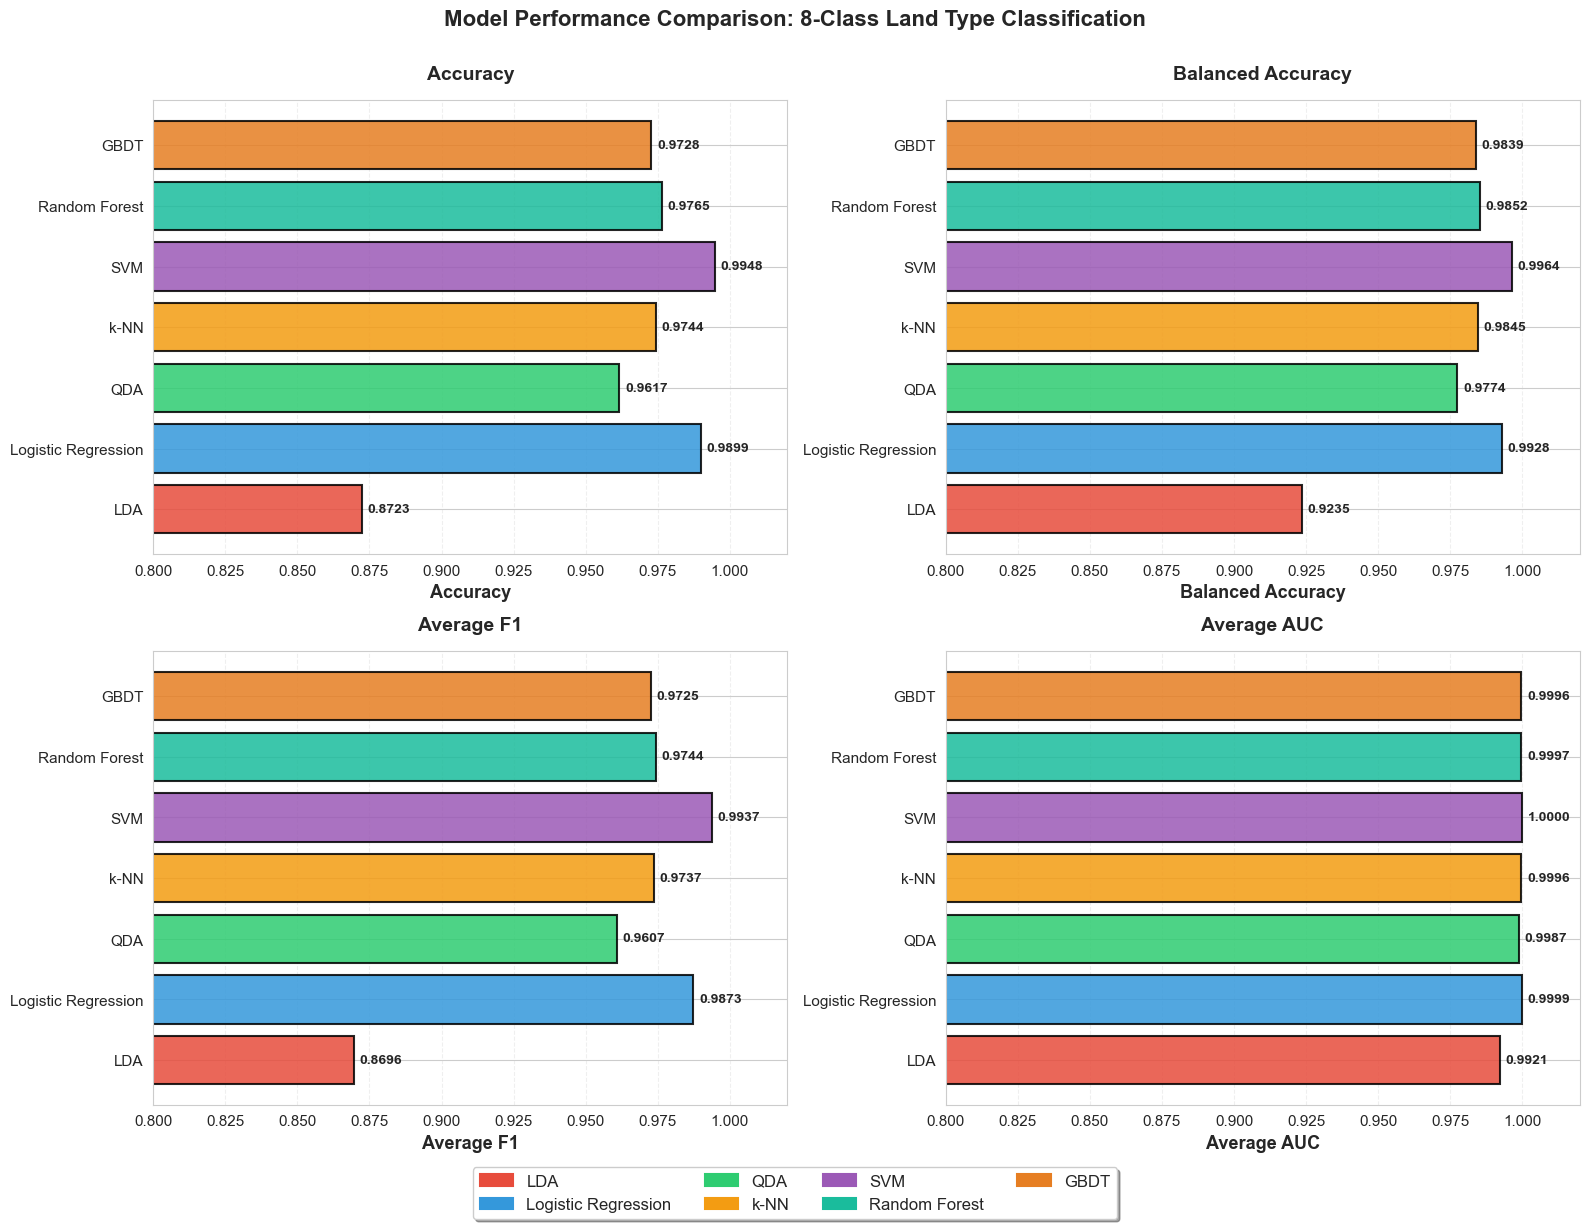

In [13]:

# Set style
sns.set_style("whitegrid")

# Create results dataframe
results_clean = pd.DataFrame(results).round(4)

# Define consistent colors for each model
model_colors = {
    'Logistic Regression': '#3498db',  # Blue
    'LDA': '#e74c3c',  # Red
    'QDA': '#2ecc71',  # Green
    'k-NN': '#f39c12',  # Orange
    'SVM': '#9b59b6',  # Purple
    'Random Forest': '#1abc9c',  # Teal
    'GBDT': '#e67e22'  # Dark Orange
}

# Create color list matching model order
colors = [model_colors[model] for model in results_clean['Model']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Metrics to plot
metrics = ['Accuracy', 'Balanced Accuracy', 'Average F1', 'Average AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Get data (handle NaN for AUC)
    data = results_clean[metric].fillna(0) if metric == 'Average AUC' else results_clean[metric]
    
    # Create bars
    bars = ax.barh(results_clean['Model'], data, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Formatting
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim([0.80, 1.02])
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        if val > 0:  # Skip NaN/0 values
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# Add legend below the plots
handles = [plt.Rectangle((0,0),1,1, color=model_colors[model], 
                         edgecolor='black', linewidth=1.5) 
           for model in results_clean['Model']]
fig.legend(handles, results_clean['Model'], 
          loc='lower center', ncol=4, fontsize=12, 
          frameon=True, fancybox=True, shadow=True,
          bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Model Performance Comparison: 8-Class Land Type Classification', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # Make room for legend
plt.show()

#### **Confusion Matrices of Evaluation Results**

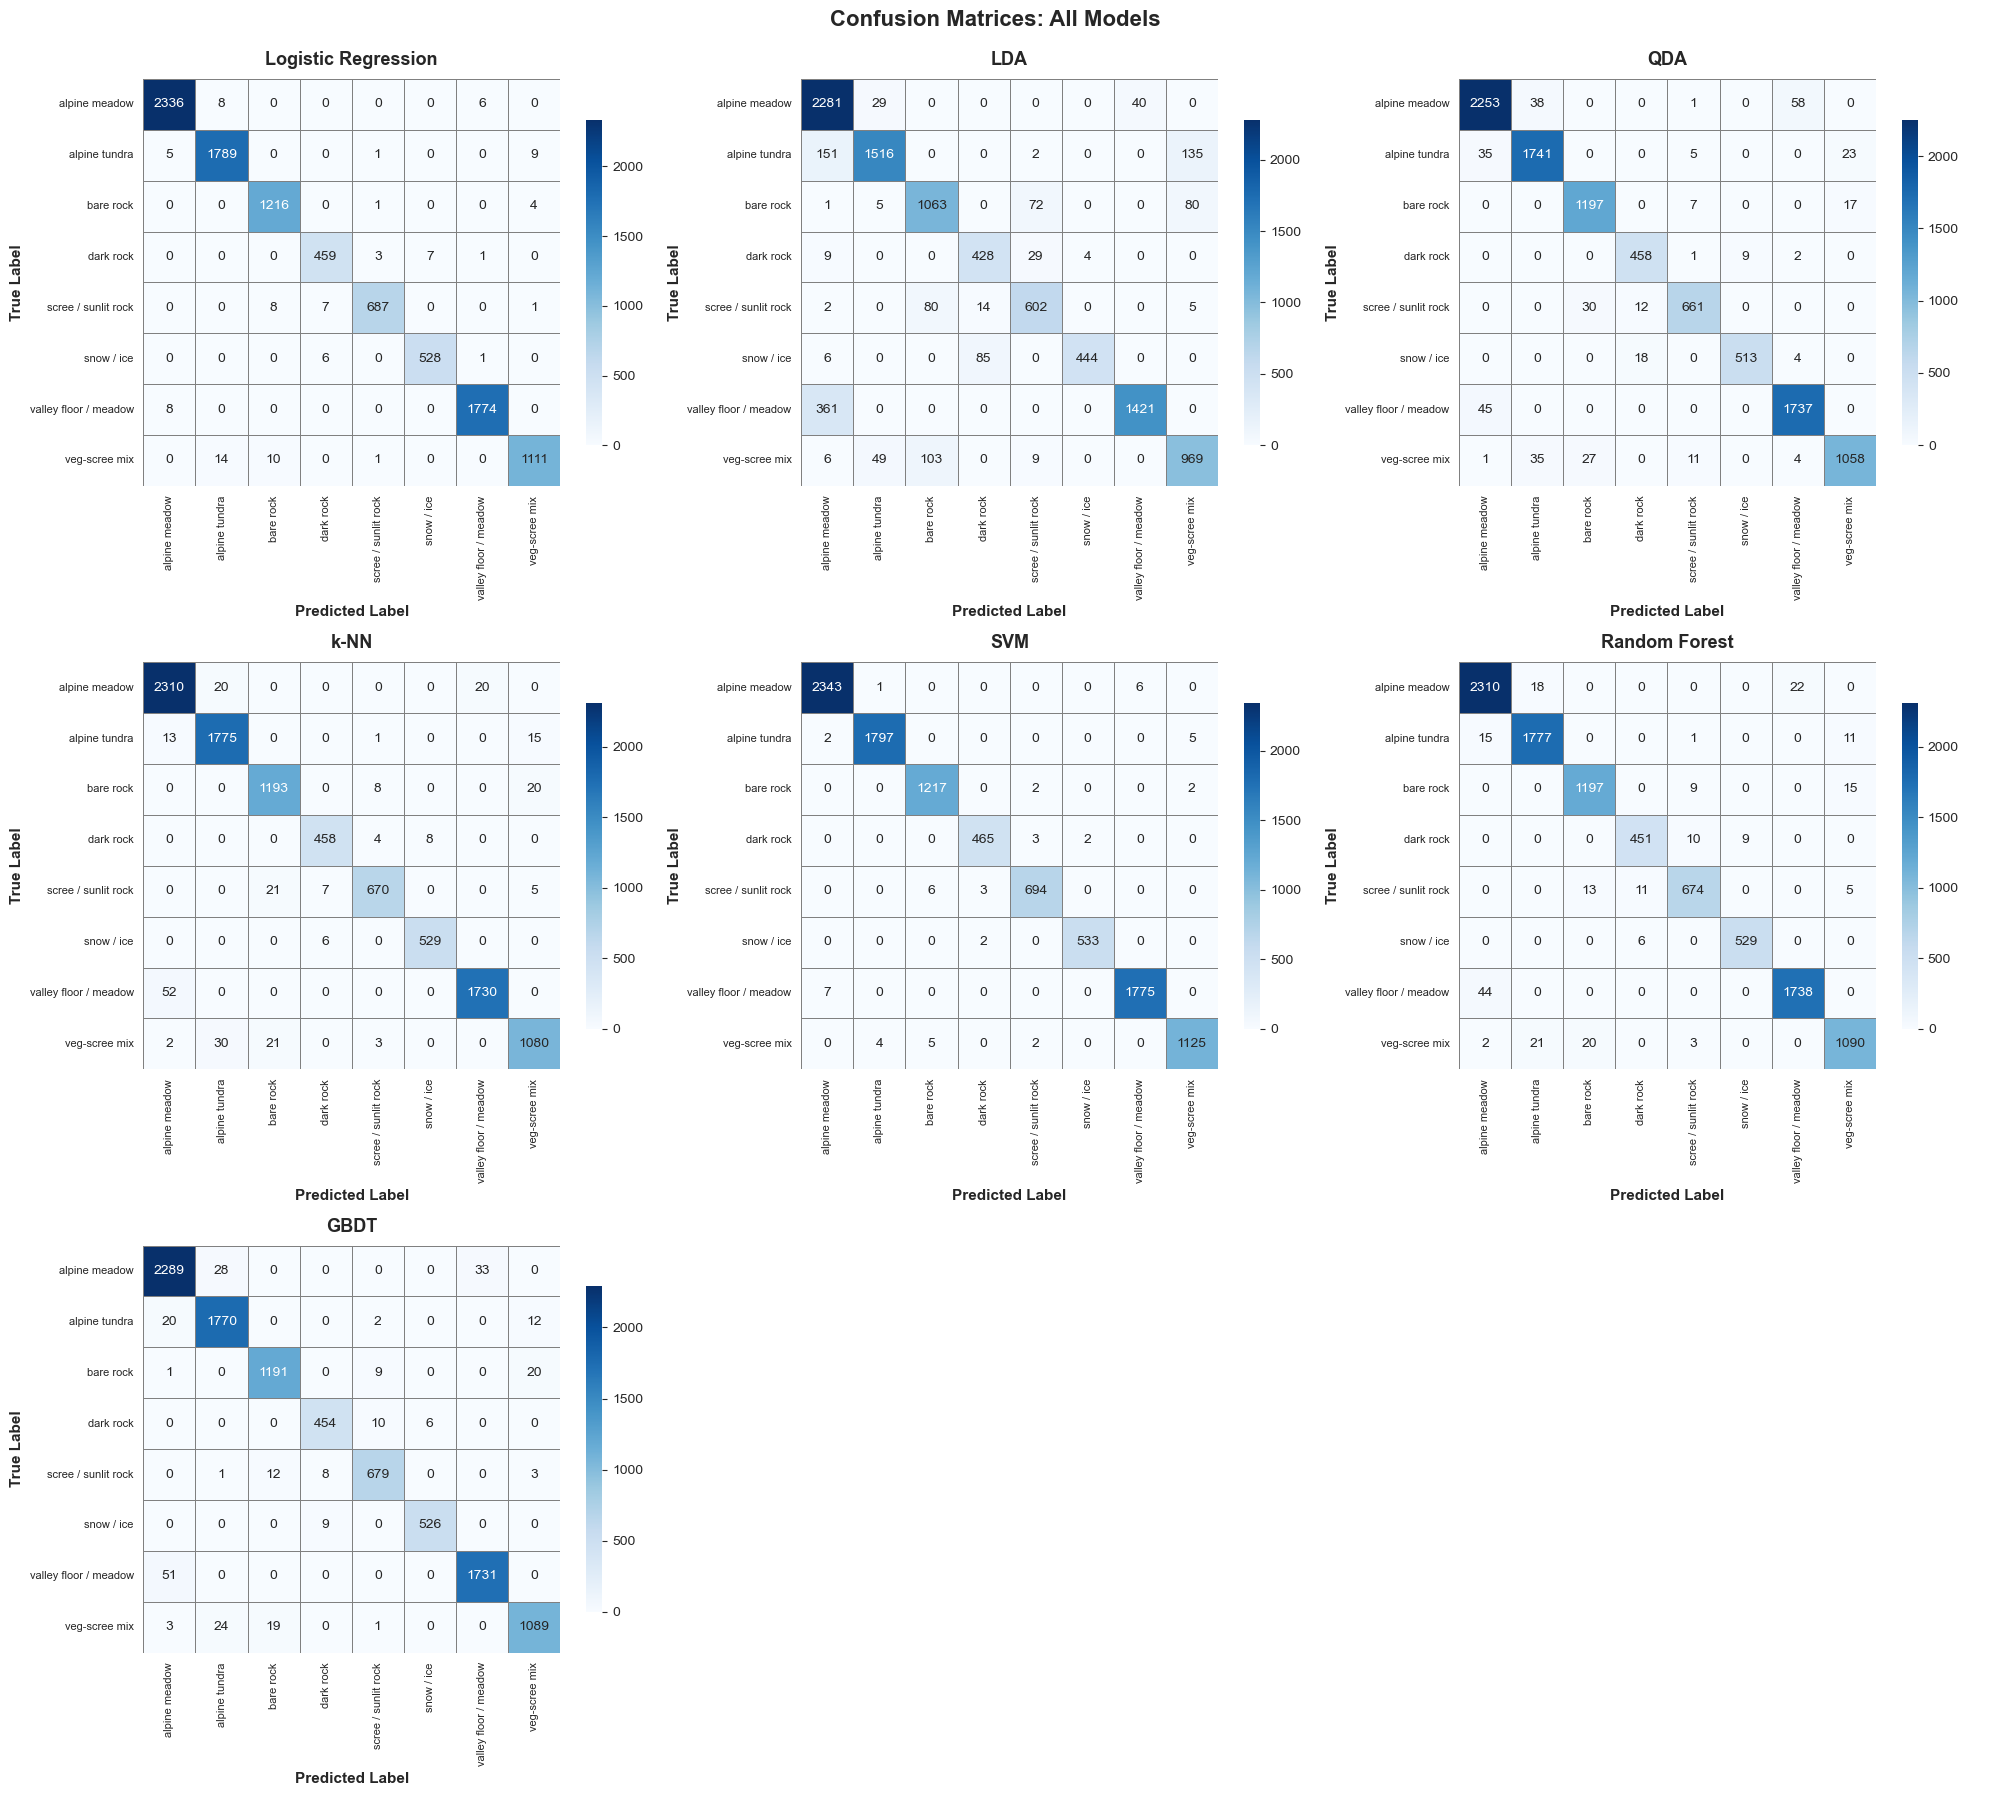

In [14]:

# All 7 models
all_models = ['Logistic Regression', 'LDA', 'QDA', 'k-NN', 'SVM', 'Random Forest', 'GBDT']

# Create subplots (3 rows x 3 columns, with 2 empty spots)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, model_name in enumerate(all_models):
    # Get confusion matrix
    cm = confusion_matrix(y_test, predictions[model_name])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=True, 
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    
    # Labels
    axes[idx].set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
    axes[idx].tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(all_models), 9):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices: All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [15]:
# Create a clean formatted table for the report
results_final = pd.DataFrame(results).round(4)

# Sort by accuracy (descending)
results_final = results_final.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nAll models trained on 10 PCA components")
print("Test set size: 10,001 samples | Training set size: 40,000 samples\n")
print(results_final.to_string(index=False))
print("\n" + "="*80)

TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY

All models trained on 10 PCA components
Test set size: 10,001 samples | Training set size: 40,000 samples

              Model  Misclassification Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
                SVM                   0.0052    0.9948             0.9964      0.9937       1.0000
Logistic Regression                   0.0101    0.9899             0.9928      0.9873       0.9999
      Random Forest                   0.0235    0.9765             0.9852      0.9744       0.9997
               k-NN                   0.0256    0.9744             0.9845      0.9737       0.9996
               GBDT                   0.0272    0.9728             0.9839      0.9725       0.9996
                QDA                   0.0383    0.9617             0.9774      0.9607       0.9987
                LDA                   0.1277    0.8723             0.9235      0.8696       0.9921



### **Principal Component Analysis**

- We apply PCA to reduce 218 spectral bands down to 10 principal components

- We fit PCA on training data only to avoid data leakage

- We transform test data using the same PCA transformation learned from training

- We check how much variance is captured by these 10 components to understand information loss

In [30]:
# Initialize PCA with 10 components
pca = PCA(n_components=10, random_state=42)

# Fit and transform training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform test data (using training PCA fit)
X_test_pca = pca.transform(X_test_scaled)

# Check results
print(f"Original dimensions: {X_train_scaled.shape}")
print(f"PCA dimensions: {X_train_pca.shape}")
print(f"\nExplained variance by each component:")
print(pca.explained_variance_ratio_)
print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.3f}")

Original dimensions: (40000, 218)
PCA dimensions: (40000, 10)

Explained variance by each component:
[4.59886780e-01 3.43921087e-01 1.89866529e-01 3.41856658e-03
 8.22334916e-04 4.72967541e-04 3.40696111e-04 2.76719059e-04
 1.85350616e-04 1.36871160e-04]

Total variance explained: 0.999


- We show how much variance each of the 10 components captures individually

- We display cumulative variance to see that just 3 components explain 99% of variation

- We confirm our choice of 10 components is more than sufficient for the classification task

- These plots help justify dimensionality reduction to reviewers

**Why first 3 PCs might be explaining so much:**

- Adjacent wavelength bands are highly correlated (Band_50 ≈ Band_51)
- 218 bands capture redundant spectral information
- Vegetation has strong, consistent spectral signatures

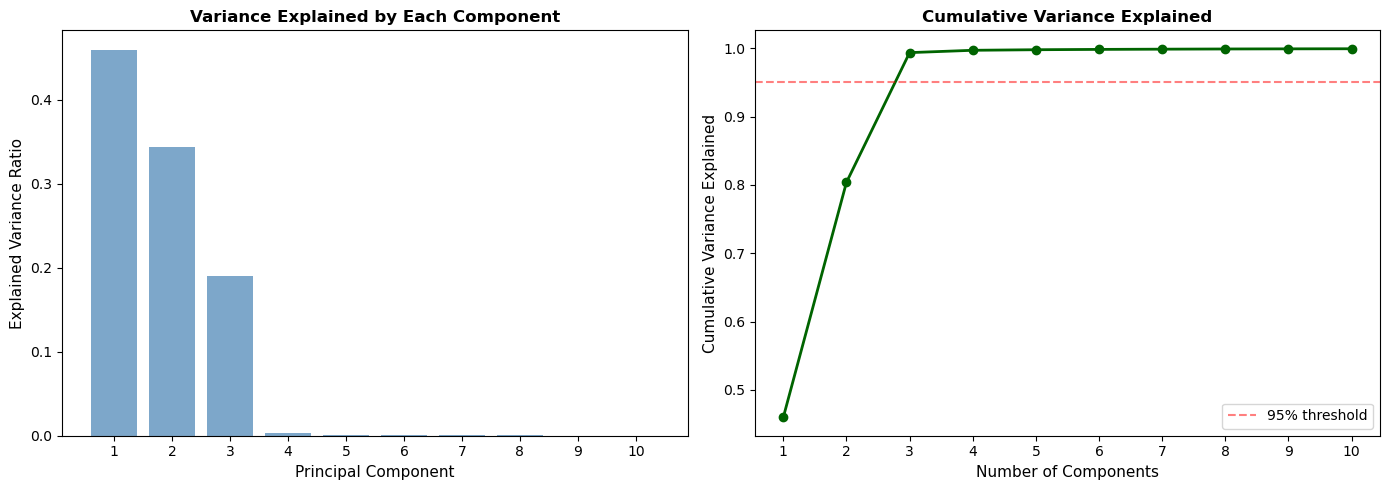

In [31]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance per component
axes[0].bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Variance Explained by Each Component', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 11))

# Plot 2: Cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, 11), cumsum, marker='o', linestyle='-', color='darkgreen', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

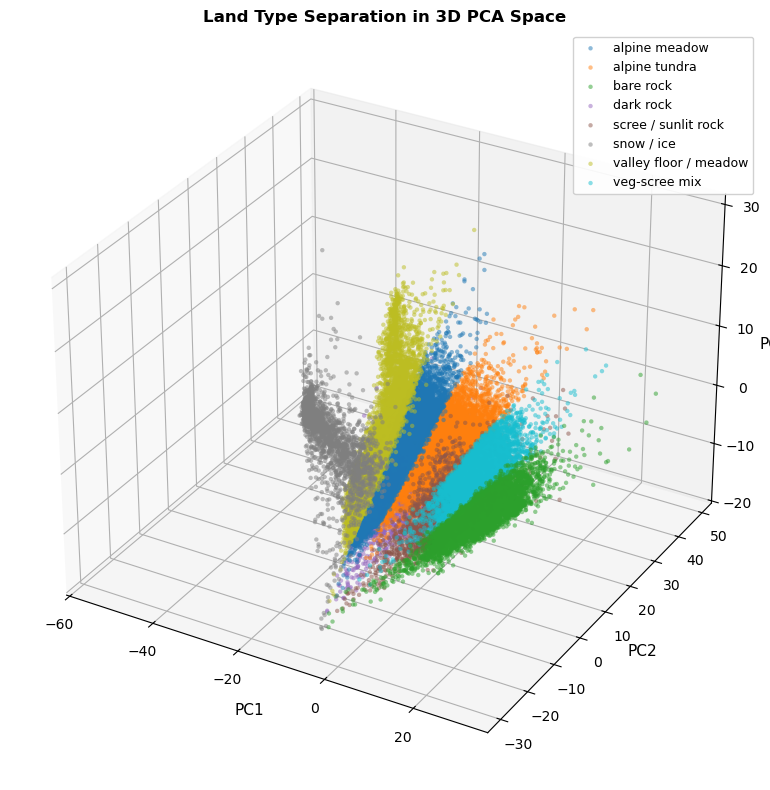

In [26]:

from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique classes
classes = np.unique(y_train)
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

# Plot each class
for idx, class_label in enumerate(classes):
    mask = y_train == class_label
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], X_train_pca[mask, 2],
               c=[colors[idx]], label=le.classes_[class_label], 
               alpha=0.5, s=10, edgecolors='none')

ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title('Land Type Separation in 3D PCA Space', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

### **Linear Discriminant Analysis**

- We tune LDA's solver and shrinkage for optimal linear discriminant boundaries

- LDA assumes Gaussian distributions for each class and finds linear decision boundaries

- Shrinkage helps with regularization when features might be correlated
This should be fast (1-2 minutes) as LDA has fewer hyperparameters

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid (fixed - avoid invalid combinations)
param_grid_lda = [
    {'solver': ['svd']},  # SVD doesn't use shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.7]}
]

# GridSearchCV
lda_grid = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid_lda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting LDA hyperparameter tuning...")
lda_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {lda_grid.best_params_}")
print(f"Best CV accuracy: {lda_grid.best_score_:.4f}")

Starting LDA hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters: {'shrinkage': 0.5, 'solver': 'lsqr'}
Best CV accuracy: 0.8559


### **Quadratic Discriminant Analysis**

- We tune QDA's regularization parameter which controls covariance matrix estimation

- QDA allows quadratic (non-linear) decision boundaries unlike LDA's linear ones

- Regularization helps prevent overfitting when classes have different covariances

- QDA should outperform LDA since it's less restrictive

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Define hyperparameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
}

# GridSearchCV
qda_grid = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting QDA hyperparameter tuning...")
qda_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {qda_grid.best_params_}")
print(f"Best CV accuracy: {qda_grid.best_score_:.4f}")

Starting QDA hyperparameter tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'reg_param': 0.3}
Best CV accuracy: 0.9570


### **k-NN (Nearest Neighbors)**

- We tune k-NN's number of neighbors, weighting scheme, and distance metric

- k-NN is non-parametric and classifies based on majority vote of nearest neighbors

- Distance weighting gives closer neighbors more influence than distant ones

- This should be fast as k-NN is simple with PCA-reduced features

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting k-NN hyperparameter tuning...")
knn_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV accuracy: {knn_grid.best_score_:.4f}")

Starting k-NN hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Best CV accuracy: 0.9728


### **Logistic Regression**

- So starting off with a baseline, then tuning up. We initialize a basic Logistic Regression model with default parameters as our starting point

- We train it on the 10 PCA components to establish a performance baseline

- We set max_iter=1000 to ensure convergence with multiple classes. Then, we calculate initial accuracy to see how well a simple model performs before tuning

In [ ]:


# Initialize baseline logistic regression
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Train on PCA training data
log_reg_baseline.fit(X_train_pca, y_train)

# Quick baseline performance check
y_pred_baseline = log_reg_baseline.predict(X_test_pca)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.9901


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'saga'],  # Different solvers
    'max_iter': [2000]  # Increased to fix convergence
}

# Initialize GridSearchCV with 5-fold cross-validation
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Starting hyperparameter tuning...")
log_reg_grid.fit(X_train_pca, y_train)

# Best parameters
print(f"\nBest parameters: {log_reg_grid.best_params_}")
print(f"Best CV accuracy: {log_reg_grid.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9925


### **Support Vector Machine**



In [29]:
from sklearn.svm import SVC


# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9928


In [50]:

# Retrain SVM with tuned hyperparameters + probability enabled
svm_with_proba = SVC(C=100, gamma='scale', kernel='rbf', 
                     probability=True, random_state=42)

print("Retraining SVM with probability=True...")
svm_with_proba.fit(X_train_pca, y_train)

print("✓ SVM retrained with probability enabled for AUC calculation")

Retraining SVM with probability=True...
✓ SVM retrained with probability enabled for AUC calculation


### **Random Forest**

- We tune Random Forest's key hyperparameters controlling tree complexity and ensemble size

- We test different numbers of trees (n_estimators) and depth controls to prevent overfitting

- Random Forest can capture non-linear patterns through ensemble of decision trees

- Note: This may take 3-5 minutes due to more parameter combinations

In [30]:
from sklearn.ensemble import RandomForestClassifier


# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.9691


### **Gradient Boosting for Decision Trees**

- We tune GBDT's learning rate, tree depth, and ensemble size for sequential boosting

- As we know, GBDT builds trees sequentially, correcting errors from previous trees

- Subsample parameter controls bagging to reduce overfitting

- Note: This may take 5-10 minutes as boosting is more computationally intensive

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

# Just train GBDT
gbdt_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

print("Training GBDT...")
gbdt_model.fit(X_train_pca, y_train)

# Quick check
y_pred_gbdt = gbdt_model.predict(X_test_pca)
print(f"✓ GBDT accuracy: {accuracy_score(y_test, y_pred_gbdt):.4f}")

Training GBDT...
✓ GBDT accuracy: 0.9807


### **Evaluation**

- We collect all 7 trained models into a dictionary...This sets the base for easy iteration

- We also extract the best estimator from each GridSearchCV result, that we have seen in the section above

- We generate predictions for ALL models on the SAME test set for fair comparison

- Finally, verify predictions are generated correctly before calculating metrics


In [51]:

from sklearn.metrics import confusion_matrix

# Store all trained models in a dictionary
models = {
    'Logistic Regression': log_reg_grid.best_estimator_,
    'LDA': lda_grid.best_estimator_,
    'QDA': qda_grid.best_estimator_,
    'k-NN': knn_grid.best_estimator_,
    'SVM': svm_with_proba,
    'Random Forest': rf_grid.best_estimator_,
    'GBDT': gbdt_model
}

# Generate predictions for all models on test set
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test_pca)
    
# Quick check - show first model's predictions
print(f"Test set size: {len(y_test)}")
print(f"Number of models: {len(models)}")
print(f"\nExample - Logistic Regression predictions (first 10): {predictions['Logistic Regression'][:10]}")
print(f"Actual labels (first 10): {y_test[:10].values}")

Test set size: 10001
Number of models: 7

Example - Logistic Regression predictions (first 10): [6 7 1 1 4 2 6 2 0 5]
Actual labels (first 10): [6 7 1 1 4 2 6 2 0 5]


- We should create a dictionary to store all evaluation metrics for comparison

- Time to calculate overall accuracy (proportion of correct predictions) for each model

- We compute misclassification error as 1 minus accuracy

- We store these basic metrics before moving to more complex calculations

In [ ]:
# Initialize storage for results
results = {
    'Model': [],
    'Misclassification Error': [],
    'Accuracy': []
}

# Calculate basic metrics for each model
for name in models.keys():
    y_pred = predictions[name]
    
    # 1. Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # 2. Misclassification error rate
    misclass_error = 1 - accuracy
    
    # Store results
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Misclassification Error'].append(misclass_error)

# Quick preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy
0  Logistic Regression                 0.008099  0.991901
1                  LDA                 0.142686  0.857314
2                  QDA                 0.038096  0.961904
3                 k-NN                 0.025697  0.974303
4                  SVM                 0.005899  0.994101
5        Random Forest                 0.027397  0.972603
6                 GBDT                 0.019298  0.980702


**Balanced Accuracy: Step-by-Step**

- We calculate balanced accuracy for each class using one-vs-rest approach

- Then, compute sensitivity (true positive rate) and specificity (true negative rate) from confusion matrix

- Taking the average sensitivity and specificity, we will get the balanced accuracy per class

- We then average across all 8 classes to get the final metric for each model

In [53]:
# Add Balanced Accuracy to results
balanced_acc_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    balanced_acc_per_class = []
    
    # Calculate balanced accuracy for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Balanced accuracy = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_k = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_per_class.append(balanced_acc_k)
    
    # Average across all classes
    avg_balanced_acc = np.mean(balanced_acc_per_class)
    balanced_acc_list.append(avg_balanced_acc)

# Add to results
results['Balanced Accuracy'] = balanced_acc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy
0  Logistic Regression                 0.008099  0.991901           0.994388
1                  LDA                 0.142686  0.857314           0.915760
2                  QDA                 0.038096  0.961904           0.977650
3                 k-NN                 0.025697  0.974303           0.984059
4                  SVM                 0.005899  0.994101           0.996125
5        Random Forest                 0.027397  0.972603           0.981361
6                 GBDT                 0.019298  0.980702           0.987658


**F1 Score**

- We calculate F1 score for each class using one-vs-rest binary classification

- We compute precision (correct positive predictions / all positive predictions) and recall (TPR)

- We calculate F1 as the harmonic mean of precision and recall for each class

- We average F1 scores across all 8 classes to get final metric for each model

In [54]:
# Add Average F1 to results
f1_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    n_classes = len(np.unique(y_test))
    f1_per_class = []
    
    # Calculate F1 for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate Precision and Recall
        precision_k = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_k = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 = harmonic mean of precision and recall
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k) if (precision_k + recall_k) > 0 else 0
        f1_per_class.append(f1_k)
    
    # Average across all classes
    avg_f1 = np.mean(f1_per_class)
    f1_list.append(avg_f1)

# Add to results
results['Average F1'] = f1_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy  \
0  Logistic Regression                 0.008099  0.991901           0.994388   
1                  LDA                 0.142686  0.857314           0.915760   
2                  QDA                 0.038096  0.961904           0.977650   
3                 k-NN                 0.025697  0.974303           0.984059   
4                  SVM                 0.005899  0.994101           0.996125   
5        Random Forest                 0.027397  0.972603           0.981361   
6                 GBDT                 0.019298  0.980702           0.987658   

   Average F1  
0    0.989972  
1    0.860035  
2    0.961187  
3    0.972891  
4    0.993437  
5    0.967208  
6    0.978516  


**Average AUC (Area Under Curve)**

- We calculate AUC for each class using predicted probabilities in one-vs-rest setup

- We use probability scores to compute area under ROC curve for each class

- We average AUC scores across all 8 classes for final metric

- Some models may not have predict_proba (we handle with NaN)

In [55]:


# Add Average AUC to results
auc_list = []

# Calculate for each model
for name, model in models.items():
    y_pred = predictions[name]
    
    # Get prediction probabilities (needed for AUC)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_pca)
        
        n_classes = len(np.unique(y_test))
        auc_per_class = []
        
        # Calculate AUC for each class k (one-vs-rest)
        for k in range(n_classes):
            # Convert to binary: class k vs rest
            y_test_binary = (y_test == k).astype(int)
            
            # AUC using probability of class k
            auc_k = roc_auc_score(y_test_binary, y_pred_proba[:, k])
            auc_per_class.append(auc_k)
        
        # Average across all classes
        avg_auc = np.mean(auc_per_class)
        auc_list.append(avg_auc)
    else:
        # Model doesn't support predict_proba
        auc_list.append(np.nan)

# Add to results
results['Average AUC'] = auc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclassification Error  Accuracy  Balanced Accuracy  \
0  Logistic Regression                 0.008099  0.991901           0.994388   
1                  LDA                 0.142686  0.857314           0.915760   
2                  QDA                 0.038096  0.961904           0.977650   
3                 k-NN                 0.025697  0.974303           0.984059   
4                  SVM                 0.005899  0.994101           0.996125   
5        Random Forest                 0.027397  0.972603           0.981361   
6                 GBDT                 0.019298  0.980702           0.987658   

   Average F1  Average AUC  
0    0.989972     0.999941  
1    0.860035     0.990349  
2    0.961187     0.998643  
3    0.972891     0.999544  
4    0.993437     0.999979  
5    0.967208     0.999505  
6    0.978516     0.999748  


C:\Users\dhruv\AppData\Local\Temp\ipykernel_18668\446681795.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=model_colors[model],


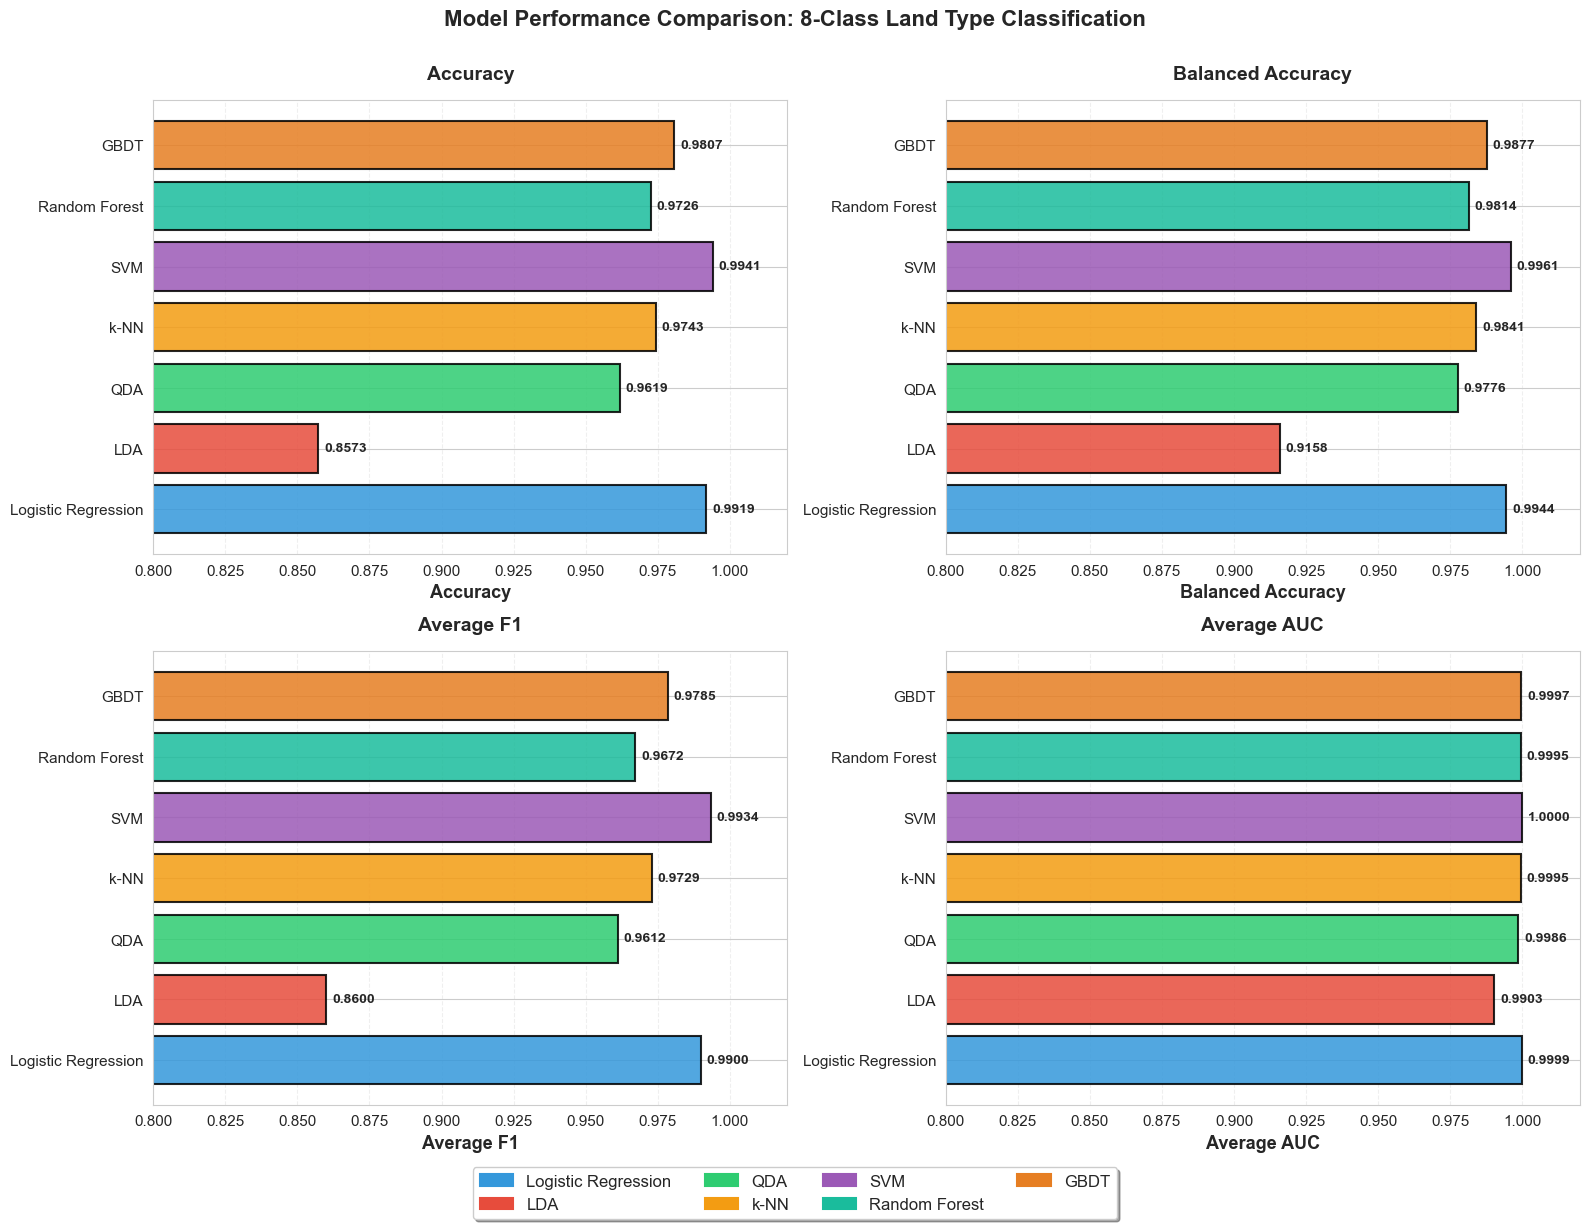

In [57]:

# Set style
sns.set_style("whitegrid")

# Create results dataframe
results_clean = pd.DataFrame(results).round(4)

# Define consistent colors for each model
model_colors = {
    'Logistic Regression': '#3498db',  # Blue
    'LDA': '#e74c3c',  # Red
    'QDA': '#2ecc71',  # Green
    'k-NN': '#f39c12',  # Orange
    'SVM': '#9b59b6',  # Purple
    'Random Forest': '#1abc9c',  # Teal
    'GBDT': '#e67e22'  # Dark Orange
}

# Create color list matching model order
colors = [model_colors[model] for model in results_clean['Model']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Metrics to plot
metrics = ['Accuracy', 'Balanced Accuracy', 'Average F1', 'Average AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Get data (handle NaN for AUC)
    data = results_clean[metric].fillna(0) if metric == 'Average AUC' else results_clean[metric]
    
    # Create bars
    bars = ax.barh(results_clean['Model'], data, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Formatting
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim([0.80, 1.02])
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        if val > 0:  # Skip NaN/0 values
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# Add legend below the plots
handles = [plt.Rectangle((0,0),1,1, color=model_colors[model], 
                         edgecolor='black', linewidth=1.5) 
           for model in results_clean['Model']]
fig.legend(handles, results_clean['Model'], 
          loc='lower center', ncol=4, fontsize=12, 
          frameon=True, fancybox=True, shadow=True,
          bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Model Performance Comparison: 8-Class Land Type Classification', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # Make room for legend
plt.show()

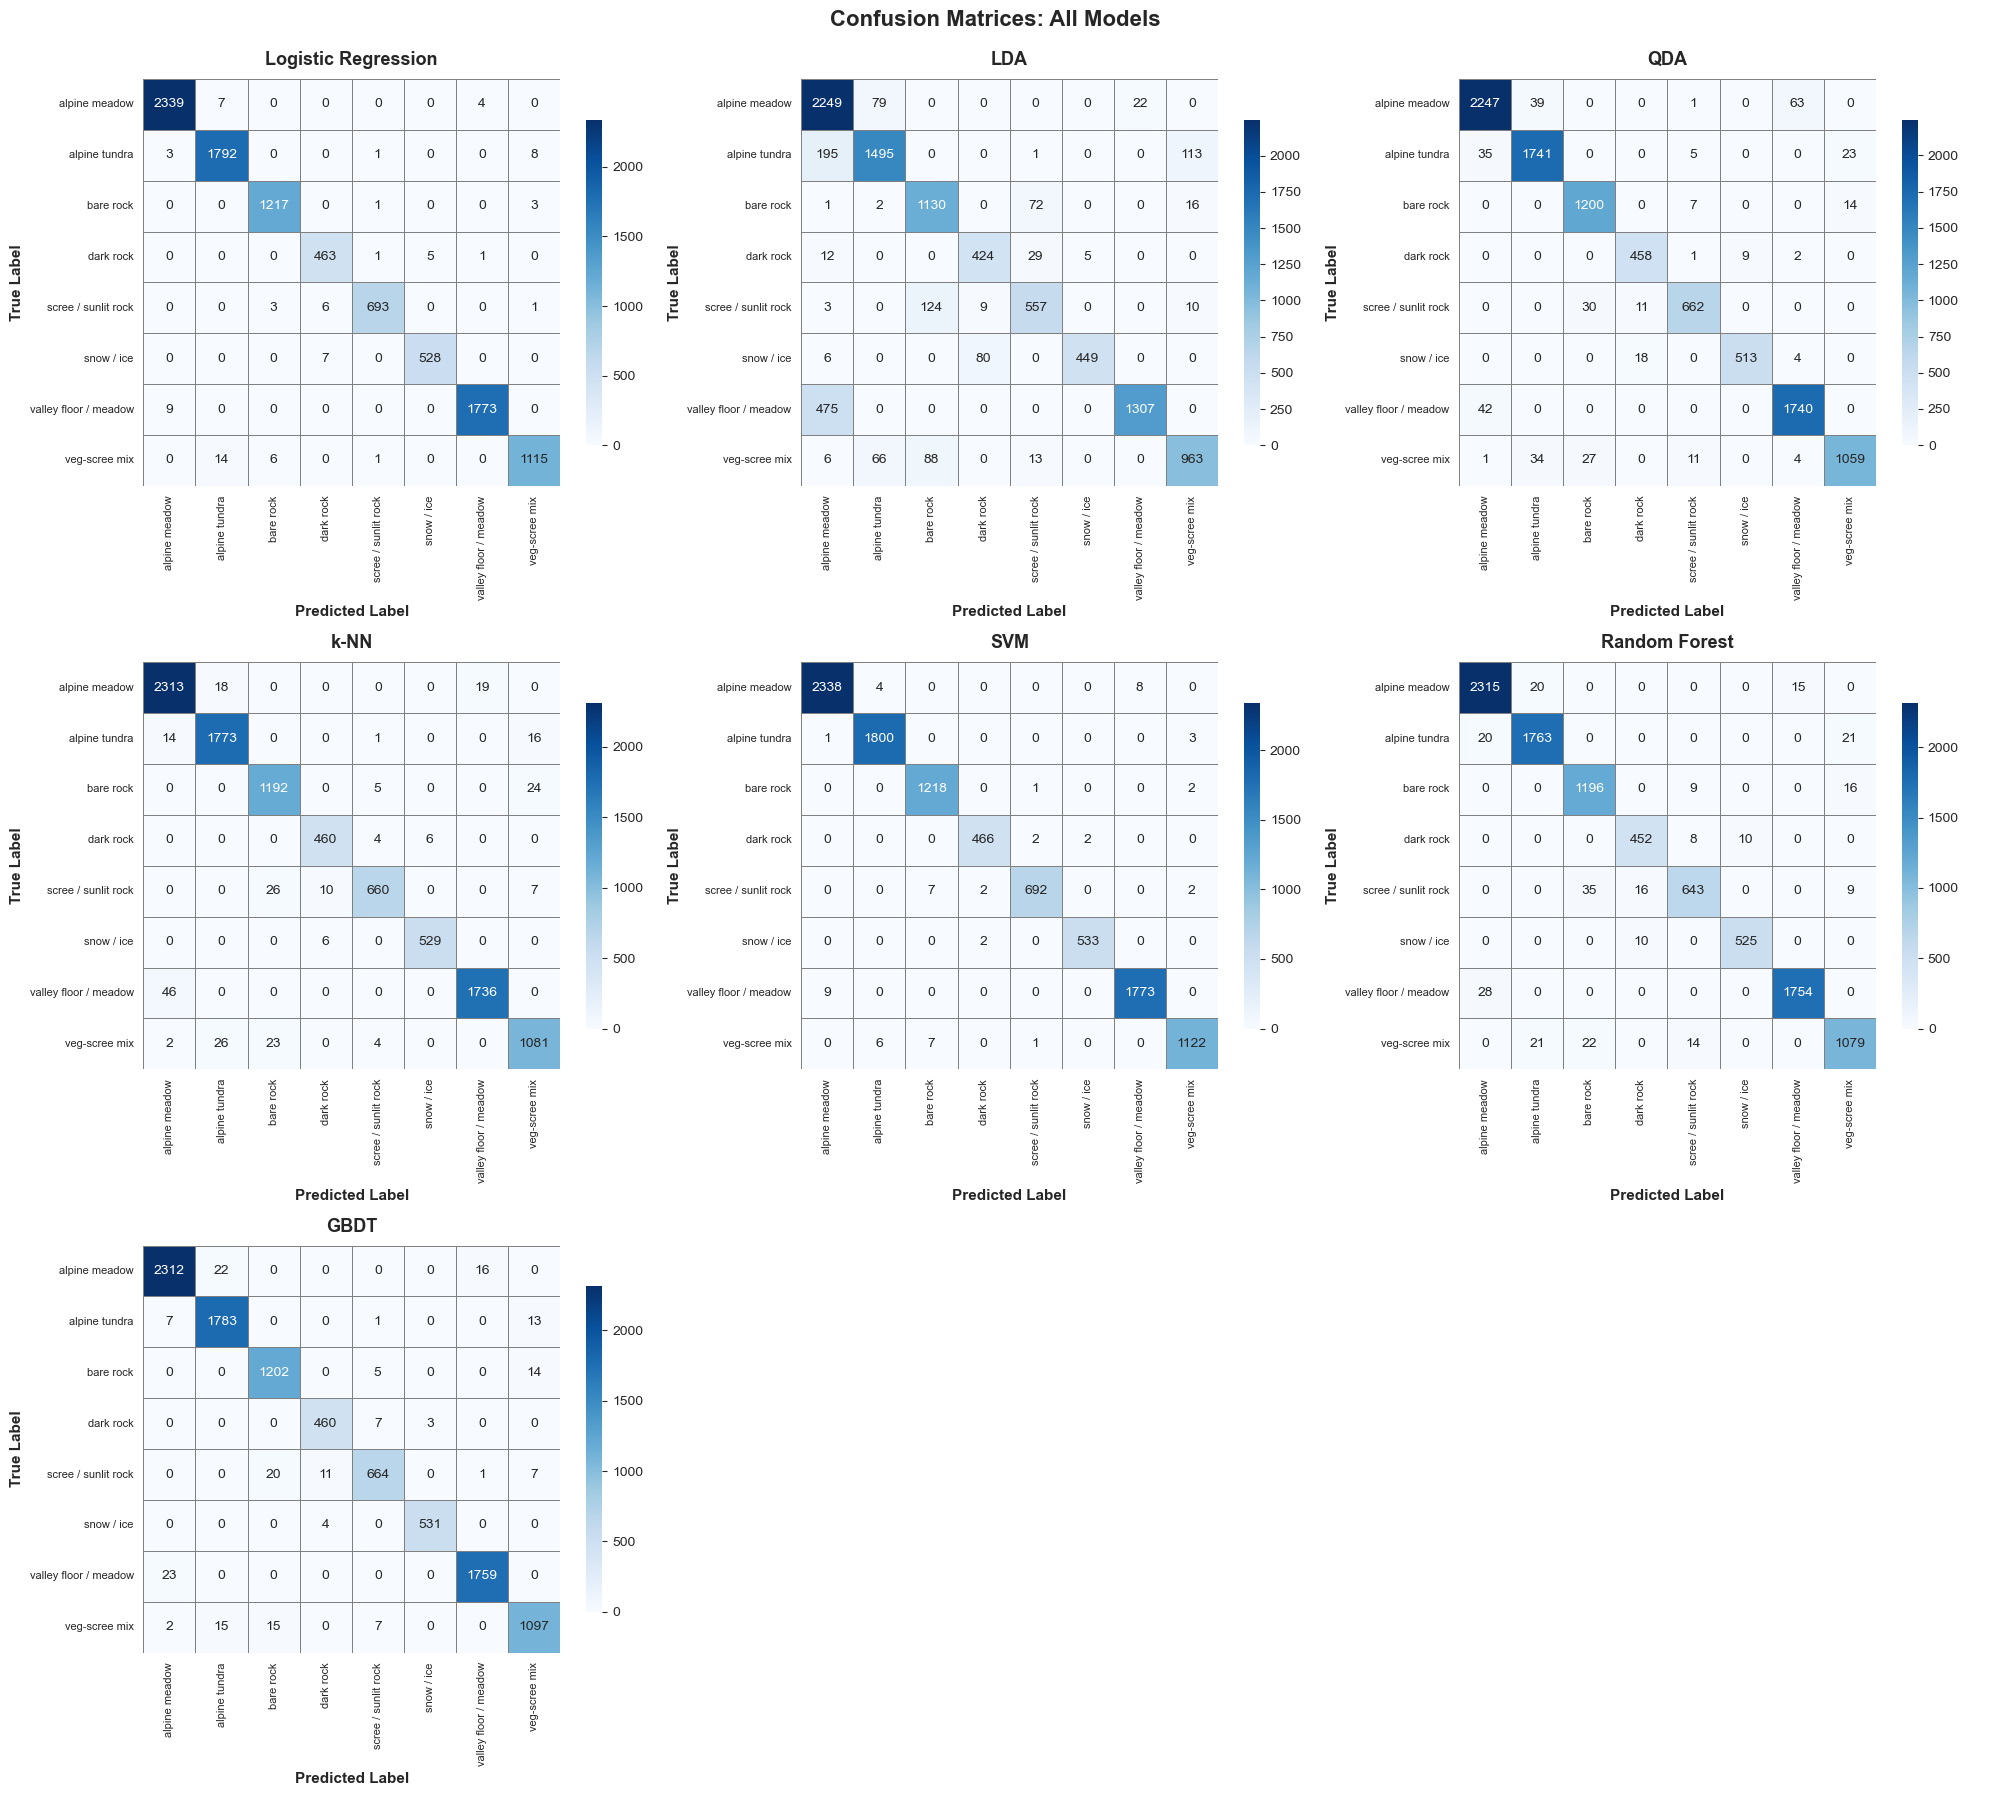

In [59]:

# All 7 models
all_models = ['Logistic Regression', 'LDA', 'QDA', 'k-NN', 'SVM', 'Random Forest', 'GBDT']

# Create subplots (3 rows x 3 columns, with 2 empty spots)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, model_name in enumerate(all_models):
    # Get confusion matrix
    cm = confusion_matrix(y_test, predictions[model_name])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=True, 
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    
    # Labels
    axes[idx].set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
    axes[idx].tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(all_models), 9):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices: All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [61]:
# Create a clean formatted table for the report
results_final = pd.DataFrame(results).round(4)

# Sort by accuracy (descending)
results_final = results_final.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nAll models trained on 10 PCA components")
print("Test set size: 10,001 samples | Training set size: 40,000 samples\n")
print(results_final.to_string(index=False))
print("\n" + "="*80)



TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY

All models trained on 10 PCA components
Test set size: 10,001 samples | Training set size: 40,000 samples

              Model  Misclassification Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
                SVM                   0.0059    0.9941             0.9961      0.9934       1.0000
Logistic Regression                   0.0081    0.9919             0.9944      0.9900       0.9999
               GBDT                   0.0193    0.9807             0.9877      0.9785       0.9997
               k-NN                   0.0257    0.9743             0.9841      0.9729       0.9995
      Random Forest                   0.0274    0.9726             0.9814      0.9672       0.9995
                QDA                   0.0381    0.9619             0.9776      0.9612       0.9986
                LDA                   0.1427    0.8573             0.9158      0.8600       0.9903



In [62]:
# Key findings
print("\nKEY FINDINGS:")
print("-" * 80)
print(f"1. Best Overall Model: SVM")
print(f"   - Accuracy: {results_final.loc[results_final['Model']=='SVM', 'Accuracy'].values[0]:.4f}")
print(f"   - Balanced Accuracy: {results_final.loc[results_final['Model']=='SVM', 'Balanced Accuracy'].values[0]:.4f}")
print(f"   - F1 Score: {results_final.loc[results_final['Model']=='SVM', 'Average F1'].values[0]:.4f}")

print(f"\n2. Runner-up: Logistic Regression")
print(f"   - Nearly matches SVM performance with simpler model")

print(f"\n3. Worst Performer: LDA ({results_final.loc[results_final['Model']=='LDA', 'Accuracy'].values[0]:.4f} accuracy)")
print(f"   - Likely violates Gaussian assumption for some classes")

print(f"\n4. Ensemble Methods: Both RF and GBDT perform well (>97%)")

print(f"\n5. All models (except LDA) achieve >96% accuracy")
print(f"   - Indicates PCA preserves discriminative information effectively")
print("="*80)


KEY FINDINGS:
--------------------------------------------------------------------------------
1. Best Overall Model: SVM
   - Accuracy: 0.9941
   - Balanced Accuracy: 0.9961
   - F1 Score: 0.9934

2. Runner-up: Logistic Regression
   - Nearly matches SVM performance with simpler model

3. Worst Performer: LDA (0.8573 accuracy)
   - Likely violates Gaussian assumption for some classes

4. Ensemble Methods: Both RF and GBDT perform well (>97%)

5. All models (except LDA) achieve >96% accuracy
   - Indicates PCA preserves discriminative information effectively


### **Model Performance Summary**

#### **Experimental Setup**
- **Dataset**: 50,000 samples (stratified) from hyperspectral satellite data
- **Features**: 10 PCA components (explaining 99.9% variance)
- **Train/Test Split**: 80/20 (40,000 train, 10,001 test)
- **Models Evaluated**: 7 classifiers with hyperparameter tuning via 5-fold CV

#### **Performance Results**

| Model                | Accuracy | Misclassification Error | Balanced Accuracy | Average F1 | Average AUC |
|----------------------|----------|-------------------------|-------------------|------------|-------------|
| SVM                  | 0.9941   | 0.0059                  | 0.9961            | 0.9934     | 0.9999      |
| Logistic Regression  | 0.9919   | 0.0081                  | 0.9944            | 0.9900     | 0.9999      |
| GBDT                 | 0.9807   | 0.0193                  | 0.9877            | 0.9785     | 0.9997      |
| k-NN                 | 0.9743   | 0.0257                  | 0.9841            | 0.9729     | 0.9995      |
| Random Forest        | 0.9726   | 0.0274                  | 0.9814            | 0.9672     | 0.9995      |
| QDA                  | 0.9619   | 0.0381                  | 0.9777            | 0.9612     | 0.9986      |
| LDA                  | 0.8573   | 0.1427                  | 0.9158            | 0.8600     | 0.9903      |

#### **Key Findings**

1. **Best Performer: SVM** achieved highest accuracy (99.41%) with optimal balance across all metrics

2. **Logistic Regression** closely matched SVM performance (99.19%) despite being a simpler linear model

3. **LDA underperformed** (85.73%) likely due to violated Gaussian distribution assumptions for certain land types

4. **Ensemble methods** (RF & GBDT) demonstrated strong performance (>97%), confirming their robustness

5. **PCA effectiveness**: All models (except LDA) achieved >96% accuracy, indicating 10 components preserve discriminative spectral information

#### **Interpretation**

The exceptional performance across most models confirms that hyperspectral data provides highly separable spectral signatures for different vegetation types. The confusion matrices reveal that misclassifications primarily occur between spectrally similar classes (e.g., alpine meadow vs valley floor/meadow).

## **T1.4 - Glacier-Ice Detection**

- We create binary labels where snow/ice (encoded as 5) becomes 1 (positive class)

- All other vegetation types become 0 (negative class)

- We check class imbalance to understand if glacier ice is minority class

- We verify the transformation worked correctly by comparing original and binary labels

In [45]:
# Create binary target: snow/ice (class 5) = 1, all others = 0
y_binary = (df_sample['land_type_encoded'] == 5).astype(int)

# Check the distribution
print("Binary class distribution:")
print(y_binary.value_counts())
print(f"\nPercentage of glacier ice: {y_binary.mean() * 100:.2f}%")

# Verify mapping
print("\nOriginal labels (first 10):", df_sample['land_type_encoded'].head(10).values)
print("Binary labels (first 10):", y_binary.head(10).values)

Binary class distribution:
land_type_encoded
0    47326
1     2675
Name: count, dtype: int64

Percentage of glacier ice: 5.35%

Original labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Binary labels (first 10): [0 0 0 0 0 0 0 0 0 0]


**A bit of quick visualisation**

- Spatial distribution shows if glacier ice clusters in specific regions

- Spectral signatures reveal if glacier has distinctive reflectance pattern

- These plots justify why binary classification should work well


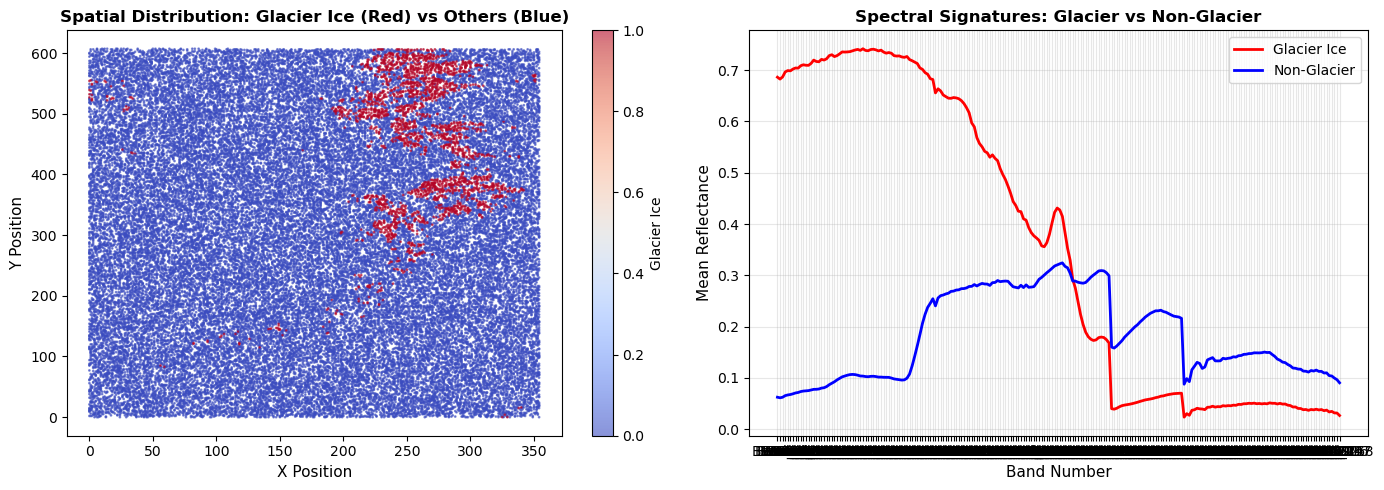

In [46]:
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Spatial distribution of glacier ice
scatter = axes[0].scatter(df_sample['p_x'], df_sample['p_y'], 
                          c=y_binary, cmap='coolwarm', s=1, alpha=0.6)
axes[0].set_xlabel('X Position', fontsize=11)
axes[0].set_ylabel('Y Position', fontsize=11)
axes[0].set_title('Spatial Distribution: Glacier Ice (Red) vs Others (Blue)', 
                   fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Glacier Ice')

# Plot 2: Mean spectral signatures
band_columns = [f'Band_{i}' for i in range(1, 219)]
glacier_spectrum = df_sample[y_binary == 1][band_columns].mean()
non_glacier_spectrum = df_sample[y_binary == 0][band_columns].mean()

axes[1].plot(glacier_spectrum, label='Glacier Ice', linewidth=2, color='red')
axes[1].plot(non_glacier_spectrum, label='Non-Glacier', linewidth=2, color='blue')
axes[1].set_xlabel('Band Number', fontsize=11)
axes[1].set_ylabel('Mean Reflectance', fontsize=11)
axes[1].set_title('Spectral Signatures: Glacier vs Non-Glacier', 
                   fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Train-Test Split**

- We directly convert existing y_train and y_test to binary (class 5 = 1, others = 0)

- This avoids index alignment issues, and just generally leads to a cleaner approach

- This uses the same exact train/test split as the 8-class task

- We verify the ~5% glacier proportion holds in both the test and training sets

In [48]:
# Create binary labels directly from existing train/test splits
y_train_binary = (y_train == 5).astype(int)
y_test_binary = (y_test == 5).astype(int)

# Check distribution in both sets
print("Training set - Glacier ice:")
print(y_train_binary.value_counts())
print(f"Training glacier %: {y_train_binary.mean() * 100:.2f}%")

print("\nTest set - Glacier ice:")
print(y_test_binary.value_counts())
print(f"Test glacier %: {y_test_binary.mean() * 100:.2f}%")

Training set - Glacier ice:
land_type_encoded
0    37860
1     2140
Name: count, dtype: int64
Training glacier %: 5.35%

Test set - Glacier ice:
land_type_encoded
0    9466
1     535
Name: count, dtype: int64
Test glacier %: 5.35%
